# Introduction to the Jaynes-Cummings-Hubbard Model: Three-Site System

Authors: Vanshaj Bindal (Cardiff University)

## Introduction

The Jaynes-Cummings-Hubbard Model (JCHM) represents a fundamental quantum system at the intersection of quantum optics and condensed matter physics. It describes an array of optical cavities, each containing a two-level atom (or other two-level system), with photons able to tunnel between neighboring cavities.

### Theoretical Background

The JCHM combines two important quantum models:

1. **Jaynes-Cummings Model**: Describes the interaction between a single two-level atom and a quantized electromagnetic field in a cavity. This model captures the fundamental light-matter interaction in cavity quantum electrodynamics (QED).

2. **Bose-Hubbard Model**: Describes bosonic particles (in our case, photons) hopping between sites in a lattice, with on-site interactions. This model is central to describing quantum phase transitions in many-body systems.

When these models are combined, the JCHM exhibits rich physics including quantum phase transitions between Mott insulator-like states (where photons are localized in cavities) and superfluid-like states (where photons are delocalized across the lattice).

### Mathematical Description

For a three-site system, the Hamiltonian can be written as:

$$H = \omega_c \sum_{i=1}^3 a_i^\dagger a_i + \frac{\omega_a}{2} \sum_{i=1}^3 \sigma_i^z + g \sum_{i=1}^3 (a_i^\dagger \sigma_i^- + a_i \sigma_i^+) - J \sum_{i=1}^2 (a_i^\dagger a_{i+1} + a_{i+1}^\dagger a_i)$$

where:
- $\omega_c$ is the cavity frequency
- $\omega_a$ is the atomic transition frequency
- $g$ is the atom-cavity coupling strength
- $J$ is the hopping strength between adjacent cavities
- $a_i^\dagger$ and $a_i$ are the creation and annihilation operators for photons in cavity $i$
- $\sigma_i^z$, $\sigma_i^+$ and $\sigma_i^-$ are the Pauli and ladder operators for atom $i$

The Hamiltonian consists of four terms:
1. Cavity energy terms: $\omega_c \sum_{i=1}^3 a_i^\dagger a_i$
2. Atom energy terms: $\frac{\omega_a}{2} \sum_{i=1}^3 \sigma_i^z$
3. Atom-cavity interaction terms: $g \sum_{i=1}^3 (a_i^\dagger \sigma_i^- + a_i \sigma_i^+)$
4. Photon hopping terms: $-J \sum_{i=1}^2 (a_i^\dagger a_{i+1} + a_{i+1}^\dagger a_i)$

### Package import

First, we'll import the necessary libraries. QuTiP (Quantum Toolbox in Python) provides the quantum operators and solvers we need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import about, basis, destroy, expect, mesolve, qeye, sigmaz, tensor

%matplotlib inline

## Constructing the Three-Site JCHM Hamiltonian

We'll start by defining the system parameters. These determine the physical properties of our quantum system:

- `N`: The number of Fock states per cavity, limiting the maximum number of photons
- `omega_c` and `omega_a`: The frequencies of the cavity and atom (in resonance when equal)
- `g`: The coupling strength between each atom and its cavity
- `J`: The hopping strength between adjacent cavities, controlling how easily photons tunnel

In [2]:
# System parameters
N = 5  # Number of Fock states per cavity(reduced for computational efficiency)
omega_c = 1.0  # Cavity frequency (sets the energy scale)
omega_a = 1.0  # Atomic transition frequency (in resonance with cavities)
g = 0.3  # Atom-cavity coupling strength
J = 0.2  # Hopping strength between cavities

### Creating the Hamiltonian

Now, we'll create a function to construct the full Hamiltonian for our three-site JCHM. This requires carefully constructing tensor products of operators to represent the combined Hilbert space of all three cavities and atoms.

The key challenge is to properly represent operators that act on specific subsystems within the total system. We use tensor products with identity operators to extend local operators to the full Hilbert space.

In [3]:
def create_three_site_jchm(N, omega_c, omega_a, g, J):
    """
    Create the Hamiltonian for a three-site Jaynes-Cummings-Hubbard model.
    In QuTiP, we construct operators for composite systems using tensor products.
    For each operator, we create a tensor product of the desired operator at the
    specific site and identity operators at all other sites.

    Parameters:
    -----------
    N : int
        Number of Fock states in each cavity.
    omega_c : float
        Cavity frequency.
    omega_a : float
        Atomic transition frequency.
    g : float
        Atom-cavity coupling strength.
    J : float
        Hopping strength between cavities.

    Returns:
    --------
    H : Qobj
        Hamiltonian for the three-site JCHM.
    ops : dict
        Dictionary of operators for measurements.
    """
    # Define operators for each cavity-atom system using tensor products
    # The full Hilbert space is: (cavity1 ⊗ atom1 ⊗ cavity2 ⊗ atom2 ⊗ cavity3 ⊗ atom3)

    # Cavity annihilation operators
    c1 = tensor(destroy(N), qeye(2), qeye(N), qeye(2), qeye(N), qeye(2))  # Cavity 1
    c2 = tensor(qeye(N), qeye(2), destroy(N), qeye(2), qeye(N), qeye(2))  # Cavity 2
    c3 = tensor(qeye(N), qeye(2), qeye(N), qeye(2), destroy(N), qeye(2))  # Cavity 3

    # Atomic Pauli operators
    sz1 = tensor(qeye(N), sigmaz(), qeye(N), qeye(2), qeye(N), qeye(2))  # Atom 1
    sz2 = tensor(qeye(N), qeye(2), qeye(N), sigmaz(), qeye(N), qeye(2))  # Atom 2
    sz3 = tensor(qeye(N), qeye(2), qeye(N), qeye(2), qeye(N), sigmaz())  # Atom 3

    # Atomic lowering operators
    sm1 = tensor(
        qeye(N), destroy(2), qeye(N), qeye(2), qeye(N), qeye(2)
    )  # Atom 1 lowering
    sm2 = tensor(
        qeye(N), qeye(2), qeye(N), destroy(2), qeye(N), qeye(2)
    )  # Atom 2 lowering
    sm3 = tensor(
        qeye(N), qeye(2), qeye(N), qeye(2), qeye(N), destroy(2)
    )  # Atom 3 lowering

    # Atomic raising operators (adjoint of lowering)
    sp1 = sm1.dag()
    sp2 = sm2.dag()
    sp3 = sm3.dag()

    # Construct the Hamiltonian

    # 1. Cavity energy terms:
    # These terms represent the energy of photons in each cavity
    H_cavity = omega_c * (c1.dag() * c1 + c2.dag() * c2 + c3.dag() * c3)

    # 2. Atom energy terms:
    # These terms represent the energy of each two-level atom
    H_atom = 0.5 * omega_a * (sz1 + sz2 + sz3)

    # 3. Cavity-atom interaction terms:
    # These terms represent the interaction between cavities and atom
    H_interaction = g * (
        (c1.dag() * sm1 + c1 * sp1)
        + (c2.dag() * sm2 + c2 * sp2)
        + (c3.dag() * sm3 + c3 * sp3)
    )

    # 4. Photon hopping terms:
    # These terms allow photons to tunnel between adjacent cavities
    H_hopping = -J * ((c1.dag() * c2 + c2.dag() * c1) + (c2.dag() * c3 + c3.dag() * c2))

    # Total Hamiltonian
    H = H_cavity + H_atom + H_interaction + H_hopping

    # Create dictionary of measurement operators for later use
    ops = {
        "cavity_n": [
            c1.dag() * c1,
            c2.dag() * c2,
            c3.dag() * c3,
        ],  # Photon number operators
        "atom_e": [
            sm1.dag() * sm1,
            sm2.dag() * sm2,
            sm3.dag() * sm3,
        ],  # Atomic excitation operators
        "cavity_a": [c1, c2, c3],  # Cavity field operators
    }

    return H, ops

Now, let's create the Hamiltonian for our system. The dimension of the resulting Hilbert space will be quite large, even with just three sites, because the total dimension scales as $(N \times 2)^3$.

In [4]:
H, ops = create_three_site_jchm(N, omega_c, omega_a, g, J)
print(f"Dimension of the Hilbert space: {H.shape}")

Dimension of the Hilbert space: (1000, 1000)


## Exploring the Ground State

The ground state of a quantum system is its lowest energy state. For the JCHM, the nature of the ground state changes as we vary the parameters, particularly the ratio of hopping strength J to coupling strength g.

In the strong coupling regime (g >> J), the ground state resembles a Mott insulator state where photons are strongly bound to atoms, forming polaritons. In the strong hopping regime (J >> g), the ground state becomes more superfluid-like, with photons delocalized across cavities.

Let's examine the ground state of our system to understand its fundamental properties:

Ground state energy: -1.633848214710543
Photon numbers in ground state: [0.02173511069447165, 0.022382202675149003, 0.02173511069447166]
Atomic excitations in ground state: [0.9782642048395852, 0.9776191662567367, 0.9782642048395853]


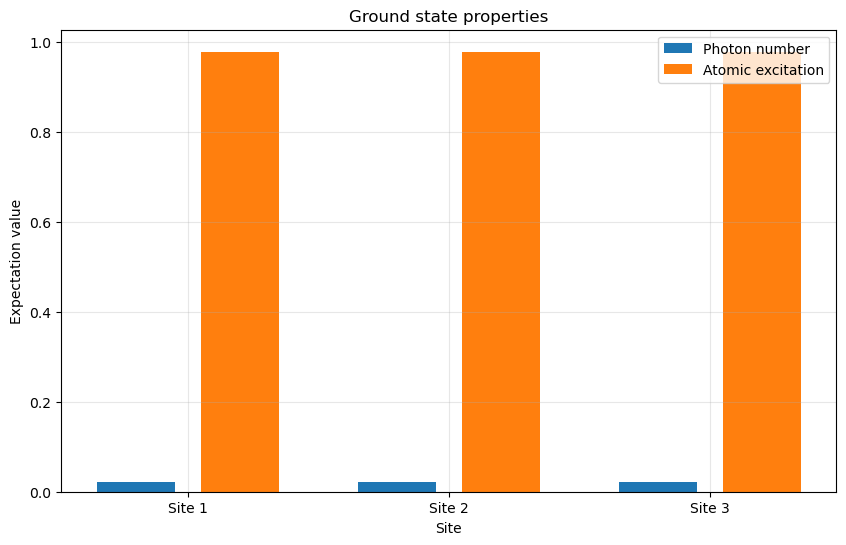

In [5]:
# Calculate ground state (lowest energy eigenstate)
evals, evecs = H.eigenstates(eigvals=1, sort="low")
ground_state = evecs[0]

# Calculate expectation values of photon numbers and atomic excitations
photon_numbers = [expect(ops["cavity_n"][i], ground_state) for i in range(3)]
atom_excitations = [expect(ops["atom_e"][i], ground_state) for i in range(3)]

# Print the values for detailed inspection
print("Ground state energy:", evals[0])
print("Photon numbers in ground state:", photon_numbers)
print("Atomic excitations in ground state:", atom_excitations)

# Plot the results to visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar([0, 1, 2], photon_numbers, width=0.3, label="Photon number")
plt.bar([0.4, 1.4, 2.4], atom_excitations, width=0.3, label="Atomic excitation")
plt.xlabel("Site")
plt.ylabel("Expectation value")
plt.title("Ground state properties")
plt.xticks([0.2, 1.2, 2.2], ["Site 1", "Site 2", "Site 3"])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Time Evolution and Dynamics

One of the most interesting aspects of the JCHM is the dynamics of photons and atomic excitations. By solving the time-dependent Schrödinger equation, we can observe how photons propagate through the cavity chain and interact with atoms.

We'll create an initial state where the first cavity has one photon and all atoms are in their ground state. This represents a localized excitation that will evolve over time.

### Theoretical Background on Dynamics

The time evolution of a quantum state is governed by the Schrödinger equation:

$$i\hbar\frac{d|\psi(t)\rangle}{dt} = H|\psi(t)\rangle$$

In QuTiP, we use the `mesolve` function to numerically solve this equation. For a closed quantum system without dissipation, the dynamics will be purely coherent, showing quantum oscillations as photons hop between cavities and interact with atoms. We usually use `sesolve` for closed quantum system, but here `mesolve` will delegate it to `sesolve`. 

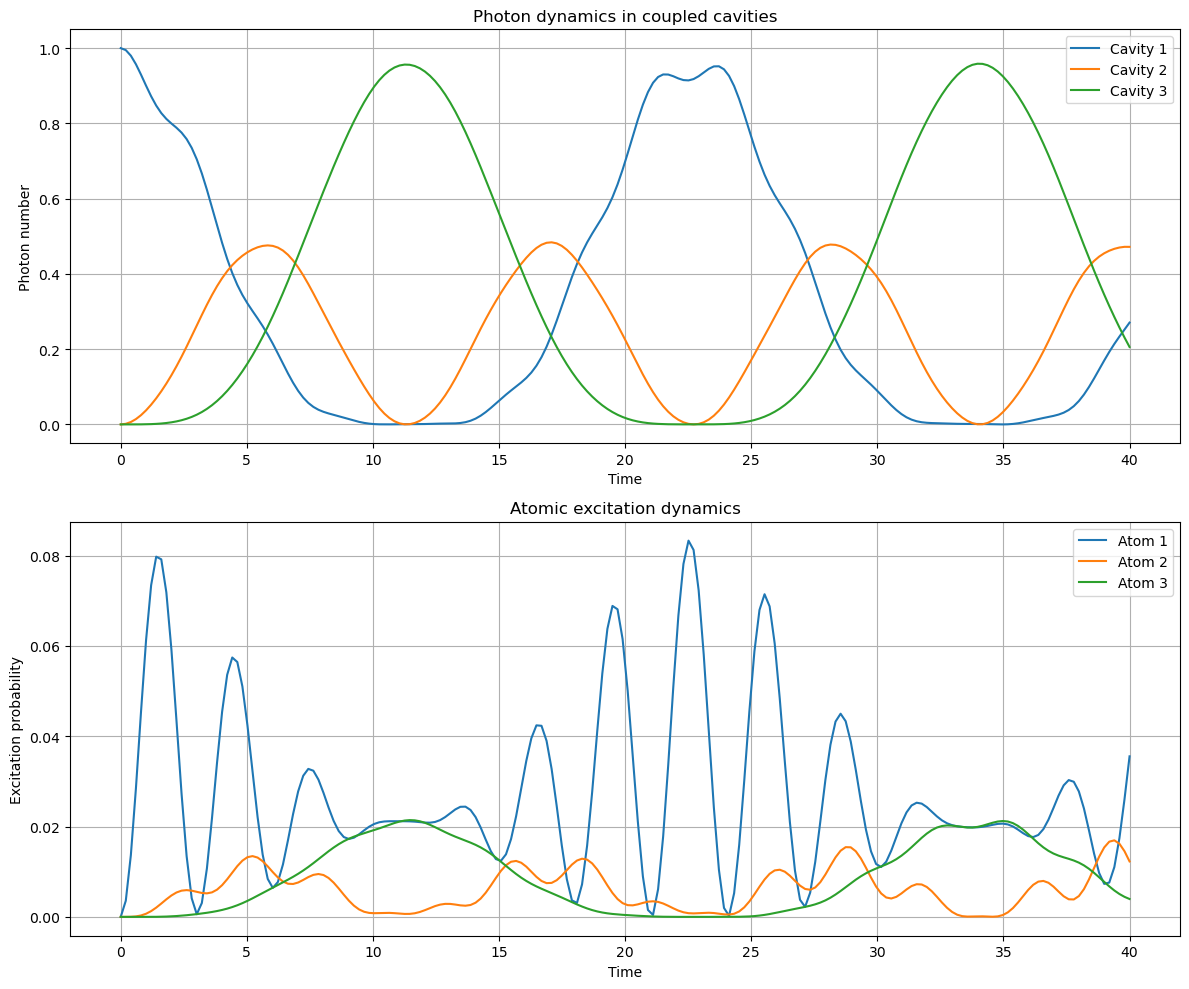

In [6]:
# Create initial state: first cavity has one photon, all atoms in ground state
# The state is a tensor product: |1⟩₁ ⊗ |g⟩₁ ⊗ |0⟩₂ ⊗ |g⟩₂ ⊗ |0⟩₃ ⊗ |g⟩₃
psi0 = tensor(
    basis(N, 1), basis(2, 0), basis(N, 0), basis(2, 0), basis(N, 0), basis(2, 0)
)

# Define time points for the evolution
tlist = np.linspace(0, 40, 200)

# Calculate time evolution using the master equation solver
# For a closed system without dissipation, this solves the Schrödinger equation
result = mesolve(H, psi0, tlist, [], e_ops=(ops["cavity_n"] + ops["atom_e"]))

# Plot the results to visualize the dynamics
plt.figure(figsize=(12, 10))

# Plot photon numbers - shows how photons move through the chain
plt.subplot(2, 1, 1)
for i in range(3):
    plt.plot(tlist, result.expect[i], label=f"Cavity {i+1}")
plt.xlabel("Time")
plt.ylabel("Photon number")
plt.title("Photon dynamics in coupled cavities")
plt.legend()
plt.grid(True)

# Plot atomic excitations - shows how atoms interact with photons
plt.subplot(2, 1, 2)
for i in range(3):
    plt.plot(tlist, result.expect[i + 3], label=f"Atom {i+1}")
plt.xlabel("Time")
plt.ylabel("Excitation probability")
plt.title("Atomic excitation dynamics")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Phase Transition Signatures

One of the most interesting aspects of the JCHM is its quantum phase transition from a Mott insulator-like phase to a superfluid-like phase as the hopping strength increases.

### Theoretical Background on Phase Transitions

In the thermodynamic limit (infinite system size), the JCHM undergoes a quantum phase transition at a critical ratio of J/g:

1. **Mott insulator phase (J < J_critical)**: Photons are localized within cavities, strongly coupled to their respective atoms, forming polaritons.

2. **Superfluid phase (J > J_critical)**: Photons are delocalized across the lattice, with long-range coherence.

While our three-site system is too small to exhibit a true phase transition, we can observe precursors or signatures of this transition by examining order parameters.

### Order Parameters

To characterize the different phases, we'll use two order parameters:

1. **Photon number fluctuations (Δn)**: Measures the variance in photon number. This increases in the superfluid phase due to greater uncertainty in photon locations.

2. **Cavity field amplitude (⟨a⟩)**: Acts as an "order parameter" that becomes non-zero in the superfluid phase.

In [7]:
def compute_order_parameters(H, ops):
    """
    Compute order parameters for the ground state of the Hamiltonian.

    Order parameters help us identify different quantum phases:
    - Photon number fluctuations (delta_n): Larger in the superfluid phase
    - Cavity field amplitude (alpha): Non-zero in the superfluid phase

    Parameters:
    -----------
    H : Qobj
        Hamiltonian of the system.
    ops : dict
        Dictionary of operators.

    Returns:
    --------
    delta_n : float
        Average photon number fluctuations.
    alpha : float
        Average cavity field amplitude.
    """
    # Find the ground state
    evals, evecs = H.eigenstates(eigvals=1, sort="low")
    ground_state = evecs[0]

    # Calculate photon numbers and fluctuations
    delta_n_values = []
    alpha_values = []

    for i in range(3):  # For all three cavities
        # Photon number
        n_op = ops["cavity_n"][i]
        n = expect(n_op, ground_state)

        # Photon number squared - needed for variance calculation
        n_sq = expect(n_op * n_op, ground_state)

        # Photon number fluctuation (standard deviation)
        delta_n = np.sqrt(n_sq - n**2)
        delta_n_values.append(delta_n)

        # Field amplitude - a measure of coherence
        a_op = ops["cavity_a"][i]
        alpha = abs(expect(a_op, ground_state))
        alpha_values.append(alpha)

    # Return average values across all cavities
    return np.mean(delta_n_values), np.mean(alpha_values)

Now let's calculate these order parameters across a range of hopping strengths to see how they change as we approach and cross the phase transition:

J = 0.500: calculated
Calculations complete!


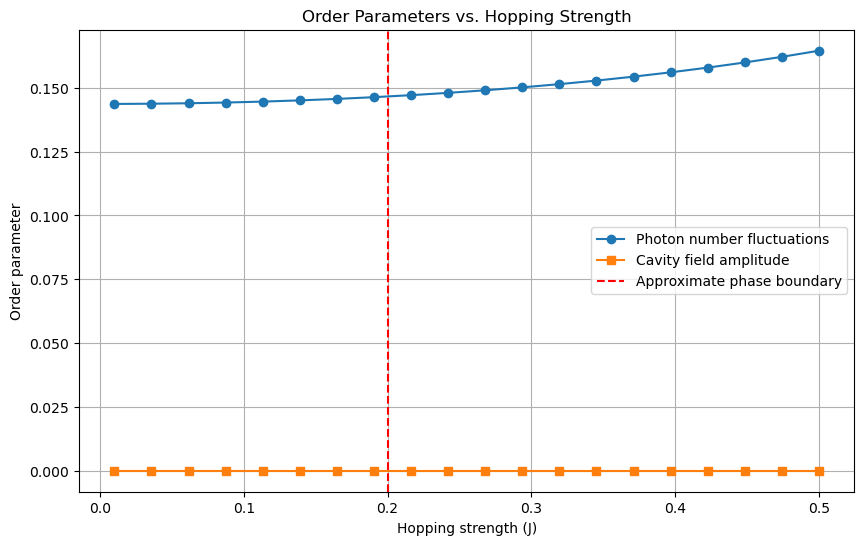

In [8]:
# Calculate order parameters for different hopping strengths
J_values = np.linspace(0.01, 0.5, 20)
delta_n_values = []
alpha_values = []

for J_val in J_values:
    # Create Hamiltonian with current J value
    H_J, ops_J = create_three_site_jchm(N, omega_c, omega_a, g, J_val)

    # Calculate order parameters
    delta_n, alpha = compute_order_parameters(H_J, ops_J)

    # Store values
    delta_n_values.append(delta_n)
    alpha_values.append(alpha)

    print(f"J = {J_val:.3f}: calculated", end="\r")

print("\nCalculations complete!")

# Plot order parameters
plt.figure(figsize=(10, 6))
plt.plot(J_values, delta_n_values, "o-", label="Photon number fluctuations")
plt.plot(J_values, alpha_values, "s-", label="Cavity field amplitude")
plt.axvline(x=0.2, color="r", linestyle="--", label="Approximate phase boundary")
plt.xlabel("Hopping strength (J)")
plt.ylabel("Order parameter")
plt.title("Order Parameters vs. Hopping Strength")
plt.legend()
plt.grid(True)
plt.show()

For a finite-size system (especially a small 3-site system), the ground state preserves certain symmetries that cause the expectation value of the field operator (⟨a⟩) to be exactly zero, even across the phase transition. The photon number fluctuations (blue circles) still increase as expected, showing a precursor to the phase transition.

In larger systems (let's say extremely large), ⟨a⟩ would become non-zero in the superfluid phase, serving as a true order parameter. But in our small system, we need to look at other quantities (like photon number fluctuations) to see signatures of the transition.

## Photon Propagation in the Chain

To better visualize how photons propagate through our three-site chain, we'll create a color map showing the photon number in each cavity over time. This provides a clear picture of the wave-like nature of photon propagation in the JCHM.

### Theoretical Background on Photon Propagation

In the JCHM, photons don't simply move from one cavity to the next in a classical way. Instead, they show quantum mechanical wave-like behavior, with interference effects and probability amplitudes spreading across the lattice. The propagation pattern depends on both the hopping strength J and the cavity-atom coupling strength g.

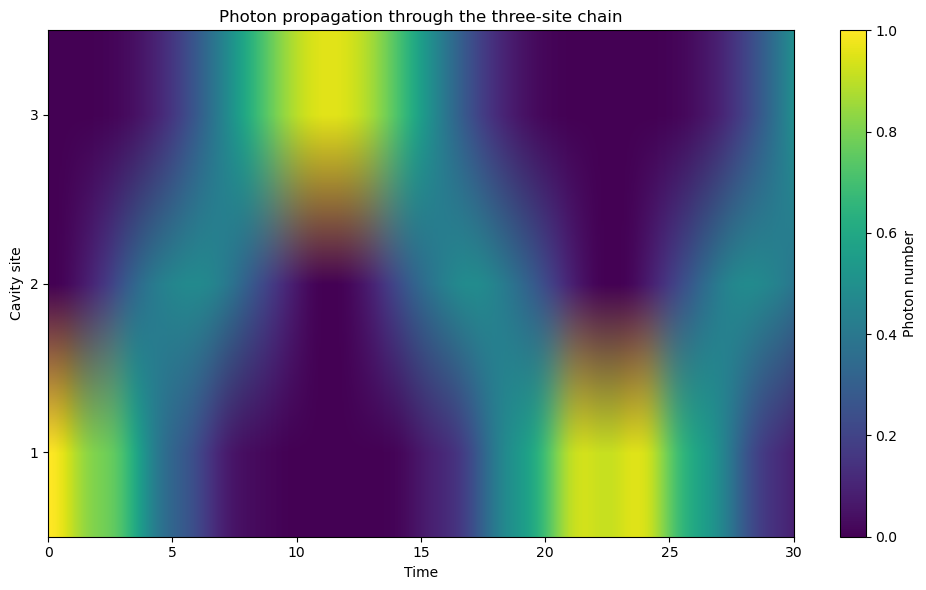

In [9]:
# Calculate time evolution with finer time resolution
tlist1 = np.linspace(0, 30, 1000)
result = mesolve(H, psi0, tlist1, [], e_ops=ops["cavity_n"])

photon_data = np.array([result.expect[0], result.expect[1], result.expect[2]])

# Create a color plot showing photon propagation
plt.figure(figsize=(10, 6))
plt.imshow(
    photon_data,
    aspect="auto",
    extent=[0, tlist1[-1], 0.5, 3.5],
    origin="lower",
    interpolation="bilinear",
    cmap="viridis",
)
plt.colorbar(label="Photon number")
plt.xlabel("Time")
plt.ylabel("Cavity site")
plt.yticks([1, 2, 3])
plt.title("Photon propagation through the three-site chain")
plt.tight_layout()
plt.show()

## Effect of Detuning

So far, we've kept the cavity and atomic frequencies in resonance (ωc = ωa). Now, let's explore what happens when we introduce detuning between them. Detuning is defined as Δ = ωa - ωc, and it significantly affects the dynamics of the system.

### Theoretical Background on Detuning

When a cavity and atom are detuned, their energy levels don't match exactly. This affects how efficiently they can exchange energy. In the JCHM, detuning can:

1. Modify the effective coupling between cavities and atoms
2. Change the speed of photon transfer through the chain
3. Alter the probability of exciting atoms

Large detuning generally reduces the effective coupling between cavities and atoms, making the system behave more like uncoupled cavities with nearly free photons.

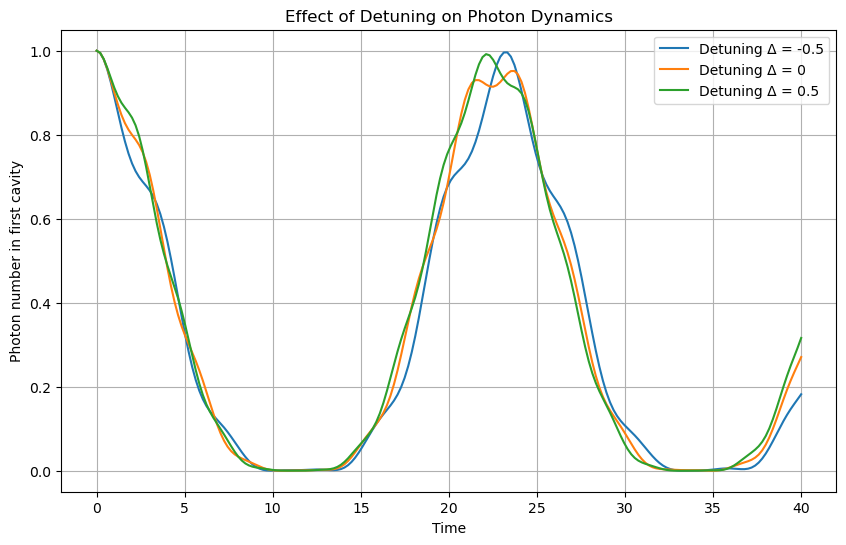

In [10]:
# Set up parameters for detuning study
delta_values = [-0.5, 0, 0.5]  # Detuning values
J_fixed = 0.2  # Fixed hopping strength

# Time parameters
tlist = np.linspace(0, 40, 200)

plt.figure(figsize=(10, 6))

for delta in delta_values:
    # Calculate new atomic frequency with detuning (Δ = ωa - ωc)
    omega_a_detuned = omega_c + delta

    # Create Hamiltonian with detuning
    H_detuned, ops_detuned = create_three_site_jchm(
        N, omega_c, omega_a_detuned, g, J_fixed
    )

    # Create initial state
    psi0 = tensor(
        basis(N, 1), basis(2, 0), basis(N, 0), basis(2, 0), basis(N, 0), basis(2, 0)
    )

    # Calculate time evolution
    result = mesolve(H_detuned, psi0, tlist, [], e_ops=[ops_detuned["cavity_n"][0]])

    # Plot photon number in first cavity
    plt.plot(tlist, result.expect[0], label=f"Detuning Δ = {delta}")

plt.xlabel("Time")
plt.ylabel("Photon number in first cavity")
plt.title("Effect of Detuning on Photon Dynamics")
plt.legend()
plt.grid(True)
plt.show()

## Varying Coupling Strength

The coupling strength g between atoms and cavities is another crucial parameter that affects the dynamics of the JCHM. Let's explore how different values of g change the photon transfer behavior.

### Theoretical Background on Coupling Strength

The atom-cavity coupling strength g determines how strongly photons interact with atoms:

1. **Weak coupling (small g)**: Photons interact weakly with atoms and can hop more freely between cavities
2. **Strong coupling (large g)**: Photons strongly interact with atoms, forming polaritons that are partly photon and partly atomic excitation
3. **Ultrastrong coupling (g ≈ ωc)**: Leads to the breakdown of the rotating wave approximation (not modeled in our simulation)

As g increases relative to J, the system moves closer to the Mott insulator phase, where photons are more strongly bound to their respective cavities.

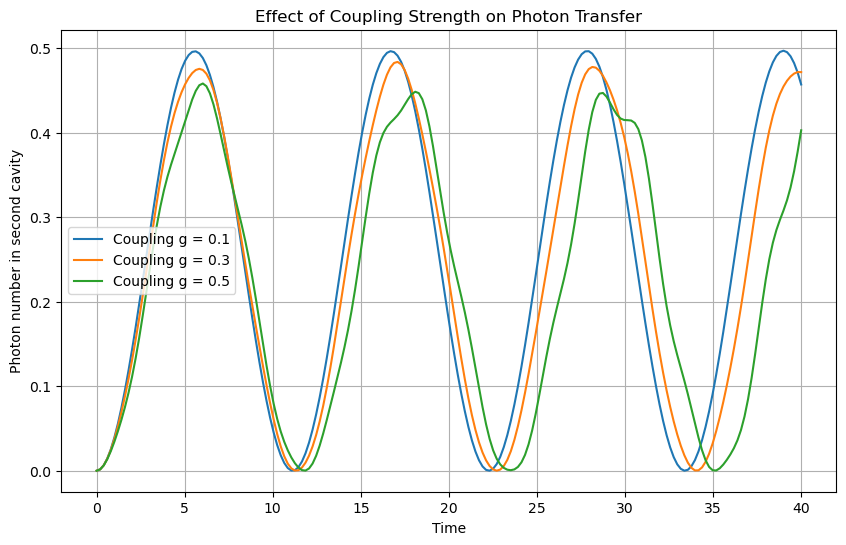

In [11]:
# Set up parameters for coupling strength study
g_values = [0.1, 0.3, 0.5]  # Different coupling strengths
J_fixed = 0.2  # Fixed hopping strength

# Time parameters
tlist = np.linspace(0, 40, 200)

plt.figure(figsize=(10, 6))

for g_val in g_values:
    # Create Hamiltonian with specific coupling strength
    H_g, ops_g = create_three_site_jchm(N, omega_c, omega_a, g_val, J_fixed)

    # Create initial state
    psi0 = tensor(
        basis(N, 1), basis(2, 0), basis(N, 0), basis(2, 0), basis(N, 0), basis(2, 0)
    )

    # Calculate time evolution
    result = mesolve(
        H_g, psi0, tlist, [], e_ops=[ops_g["cavity_n"][1]]
    )  # Measure photon number in second cavity

    # Plot photon number in second cavity
    plt.plot(tlist, result.expect[0], label=f"Coupling g = {g_val}")

plt.xlabel("Time")
plt.ylabel("Photon number in second cavity")
plt.title("Effect of Coupling Strength on Photon Transfer")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In this tutorial, we've explored the Jaynes-Cummings-Hubbard Model using a three-site system implemented in QuTiP. This model bridges quantum optics and condensed matter physics, offering insights into light-matter interactions in coupled cavity systems.

### Key Physical Insights:

1. **Ground State Properties**: The ground state of the JCHM shows the formation of polaritons, with high atomic excitation and low photon numbers.

2. **Quantum Dynamics**: Photons propagate through the cavity chain in a wave-like manner, showing quantum interference effects rather than classical particle-like behavior.

3. **Phase Transition Signatures**: Even in our small system, we observe precursors of the Mott insulator to superfluid phase transition as hopping strength increases.

4. **Parametric Dependencies**: The system's behavior is highly sensitive to detuning and coupling strength, with these parameters controlling the balance between localization and delocalization of excitations.

The JCHM has important applications in quantum simulation, quantum optics, and quantum information processing. It serves as a building block for understanding more complex quantum optical lattice systems and could potentially be implemented in various experimental platforms including superconducting circuits, photonic crystals, and cold atoms in optical lattices.

## Software version

In [12]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
